# Blood Glucose Prediction

## Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')

# Exploratory data analysis

In [3]:
print(f'Train Data Shape: {df_train.shape}')
print(f'Test Data Shape: {df_test.shape}')

Train Data Shape: (177024, 508)
Test Data Shape: (3644, 507)


In [7]:
print(f'Train data null values: {df_train.isnull().sum()}')
print(f'Test data null values: {df_test.isnull().sum()}')

Train data null values: id                    0
p_num                 0
time                  0
bg-5:55           27254
bg-5:50           18491
                  ...  
activity-0:15    174293
activity-0:10    174287
activity-0:05    174271
activity-0:00    174287
bg+1:00               0
Length: 508, dtype: int64
Test data null values: id                  0
p_num               0
time                0
bg-5:55           984
bg-5:50           583
                 ... 
activity-0:20    3580
activity-0:15    3587
activity-0:10    3586
activity-0:05    3581
activity-0:00    3583
Length: 507, dtype: int64


In [8]:
print(f'Train data duplicate values: {df_train.duplicated().sum()}')
print(f'Test data duplicate values: {df_test.duplicated().sum()}')

Train data duplicate values: 0
Test data duplicate values: 0


In [9]:
# Reducing memory of both train and test dataframe

def reduce_memory(df):
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype

        if col_type.kind in ['i', 'u', 'f']:  # int, unsigned int, float
            df[col] = pd.to_numeric(df[col], downcast='integer' if col_type.kind in ['i', 'u'] else 'float')
        elif col_type == 'object':
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage reduced from {start_mem:.2f} MB to {end_mem:.2f} MB "
          f"({(100 * (start_mem - end_mem) / start_mem):.1f}% reduction)")

    return df

In [11]:
df_train = reduce_memory(df_train)
df_test = reduce_memory(df_test)

Memory usage reduced from 686.10 MB to 311.18 MB (54.6% reduction)
Memory usage reduced from 14.10 MB to 6.46 MB (54.2% reduction)


## Data Cleaning & Preprocessing

In [12]:
# Encoding categorical variables

from sklearn.preprocessing import LabelEncoder
categorical_columns = df_train.select_dtypes(include="category").columns

for col in categorical_columns:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.fit_transform(df_test[col])

In [13]:
# Dropping columns with more than 60% missing values

numeric_columns = df_train.select_dtypes("number")
df_train = df_train.dropna(thresh=int(0.6 * len(df_train)), axis=1)

In [14]:
# Identifying and dropping columns with low variances

variances = numeric_columns.var()
low_variance_cols = variances[variances < 1].index.tolist()
df_train = df_train.drop(columns=low_variance_cols)
print("Dropped columns with low variance:", low_variance_cols)

In [18]:
# Selected columns

selected_columns = [
     "bg-2:45", "bg-2:30", "bg-2:15", "bg-2:00", "bg-1:45",
    "bg-1:30", "bg-1:15","bg-1:00", "bg-0:45", "bg-0:30",
    "bg-0:15", "bg-0:00", "bg+1:00",
    "activity-3:35", "activity-4:05", "activity-3:50",
    "activity-4:20", "activity-4:15", "activity-4:25",
    "activity-3:05", "activity-3:20", "activity-0:05",
    "activity-2:50", "activity-2:35", "activity-2:05",
    "activity-0:20", "activity-0:15", "activity-0:10",
    "activity-0:00", "activity-4:35", "activity-4:30",
    "id", "activity-4:40", "activity-5:30", "time",
    "p_num", "activity-5:55", "activity-5:50",
    "activity-5:45", "activity-5:40", "activity-5:35",
    "activity-5:25", "activity-4:45", "activity-5:20",
    "activity-5:15", "activity-5:10", "activity-5:05",
    "activity-5:00", "activity-4:55", "activity-4:50",
]

df_train = df_train[selected_columns]
df_test = df_test[[col for col in selected_columns if col in df_test.columns]]

In [19]:
# Imputeing Missing values with KNNImputer

from sklearn.impute import KNNImputer
import gc

numeric_trainColl = df_train.select_dtypes("number")
numeric_testColl = df_test.select_dtypes("number")

imputer = KNNImputer(n_neighbors=5)
train_imputed = imputer.fit_transform(numeric_trainColl)
train = pd.DataFrame(train_imputed, columns=numeric_trainColl.columns)

imputer = KNNImputer(n_neighbors=5)
test_imputed = imputer.fit_transform(numeric_testColl)
test = pd.DataFrame(test_imputed, columns=numeric_testColl.columns)
gc.collect()

del numeric_trainColl, numeric_testColl, train_imputed, test_imputed

print("Remaining missing values in train:", train.isnull().sum().sum())
print("Remaining missing values in test:", test.isnull().sum().sum())

Remaining missing values in train: 0
Remaining missing values in test: 0


In [20]:
# Removing outliers using IQR

Q1 = train['bg+1:00'].quantile(0.25)
Q3 = train['bg+1:00'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_cleaned = train[(train['bg+1:00'] >= lower_bound) & (train['bg+1:00'] <= upper_bound)]
gc.collect()

del Q1, Q3, IQR, lower_bound, upper_bound

In [ ]:
from sklearn.model_selection import train_test_split

X = df_cleaned.drop(columns="bg+1:00")
y = df_cleaned['bg+1:00']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Building & Evaluation

In [22]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [26]:
ann_model = Sequential()
ann_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
ann_model.add(Dropout(0.3))
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dropout(0.3))
ann_model.add(Dense(1))

In [36]:
ann_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [29]:
ann_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           3,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,313 (20.75 KB)

 Trainable params: 5,313 (20.75 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [37]:
history = ann_model.fit(X_train_scaled, y_train, epochs=100, batch_size=10,
                        validation_split=0.2, callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
11043/11043 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 4.0947 - val_loss: 3.6574 - learning_rate: 0.0010
Epoch 2/100
11043/11043 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - loss: 3.9629 - val_loss: 3.6469 - learning_rate: 0.0010
Epoch 3/100
11043/11043 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 3.8366 - val_loss: 3.6002 - learning_rate: 0.0010
Epoch 4/100
11043/11043 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 3.7959 - val_loss: 3.6280 - learning_rate: 0.0010
Epoch 5/100
11043/11043 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 3.7745 - val_loss: 3.5896 - learning_rate: 0.0010
Epoch 6/100
11043/11043 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 3.7941 - val_loss: 3.5898 - learning_rate: 0.0010
Epoch 7/100
11043/11043 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 3.7694 - val_loss: 3.5406 - learning_rate: 0.0010
Epoch 8/100
11043/11043 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 3.7433 - val_loss: 3.6163 - learning_rate: 0.0010
Epoch 9/100
11043/11043 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 3.7409

In [39]:
ann_predictions = ann_model.predict(X_test_scaled)
ann_rmse = np.sqrt(mean_squared_error(y_test, ann_predictions))

1079/1079 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


7282

ANN RMSE: 1.8501


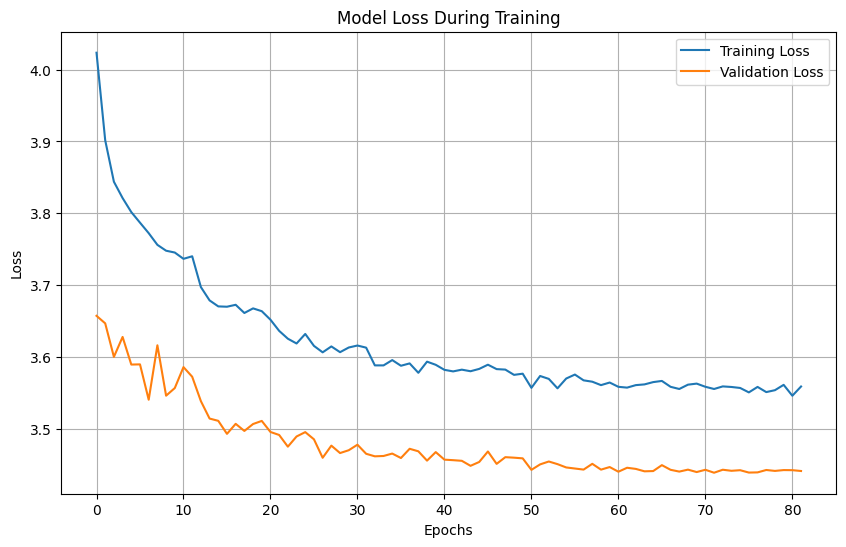

In [40]:
# Plotting the loss

print(f"ANN RMSE: {ann_rmse:.4f}")
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()